In [1]:
%matplotlib inline

In [2]:
import sys
import os 
from glob import glob
import json

In [3]:
sys.path.insert(0, '../../')

In [4]:
import paleopy

In [5]:
from paleopy import plotting

In [6]:
from paleopy import Proxy 
from paleopy import Analogs
from paleopy import Ensemble
from paleopy.plotting import scalar_plot

In [47]:
# %%writefile /Users/nicolasf/CODE/paleopy/paleopy/plotting/vector_plot.py
import numpy as np
from numpy import ma
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap as bm
from mpl_toolkits.basemap import addcyclic, shiftgrid
import palettable

class vector_plot:
    """
    plots vector plots (uwnd + vwnd) on top of geopotential anomalies (ht)

    Parameters
    ----------

    ucompos : object, composite anomalies and metadata for zonal wind component
            a composite object coming from e.g. `uwnd_1000 = analogs(ens, 'ncep', 'uwnd_1000').composite()`

    vcompos : object, composite anomalies and metadata for meridional wind component
            a composite object coming from e.g. `vwnd_1000 = analogs(ens, 'ncep', 'vwnd_1000').composite()`

    hgtcompos : object, composite anomalies and metadata for HGT
            a composite object coming from e.g. `hgt_1000 = analogs(ens, 'ncep', 'hgt_1000').composite()`

    """
    def __init__(self, ucompos, vcompos, hgtcompos):
        
        self.hgtcompos = hgtcompos
        self.ucompos = ucompos
        self.vcompos = vcompos
        self.uanoms  = ucompos.dset_compos['composite_anomalies']
        self.vanoms  = vcompos.dset_compos['composite_anomalies']
        self.hanoms  = hgtcompos.dset_compos['composite_anomalies'] 
        self.windspeed = np.sqrt(self.uanoms**2 + self.vanoms**2)

    def _get_levels(self, data):
        """
        data can be either the data array attached to:

        + self.analogs.dset_compos['composite_anomalies']

        or one of the data arrays attached to

        + self.analogs.dset_compos['composite_sample']
        """

        # ravel and removes nans for calculation of intervals etc
        calc_data = np.ravel(data[np.isfinite(data)])

        # the following is borrowed from xray
        # see: plot.py in xray/xray/plot
        vmin = np.percentile(calc_data, 1)
        vmax = np.percentile(calc_data, 99)

        del(calc_data)

        # Simple heuristics for whether these data should  have a divergent map
        divergent = ((vmin < 0) and (vmax > 0))

        # A divergent map should be symmetric around the center value
        if divergent:
            center = 0
            vlim = max(abs(vmin), abs(vmax))
            vmin, vmax = -vlim, vlim

        if (vmin.dtype == 'float64') and (vmax.dtype == 'float64'):
            vmin = float("{:6.2f}".format(vmin))
            vmax = float("{:6.2f}".format(vmax))

        levels = np.linspace(vmin, vmax, num=10, endpoint=True)

        if divergent:
            neglevels = levels[levels < 0 ]
            poslevels = levels[levels > 0 ]
            levels = [neglevels,poslevels]
            # get the colormap defined in the dset_dict for HGT
            cmap = eval(self.hgtcompos.dset_dict['plot']['cmap'])
        else:
            # get the default matplotlib colormap
            cmap = plt.get_cmap()

        return vmin, vmax, levels, cmap
    
    def plot(self, domain = [0., 360., -90., 90.], res='c', stepp=1, scale=8):
        
        latrev = (self.windspeed.latitudes[-1] < self.windspeed.latitudes[0])
        
        if latrev: 
            ugrid = self.uanoms.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[3],domain[2]))
            vgrid = self.vanoms.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[3],domain[2]))
            hgrid = self.hanoms.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[3],domain[2]))
            wgrid = self.windspeed.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[3],domain[2]))
        else: 
            ugrid = self.uanoms.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[2],domain[3]))
            vgrid = self.vanoms.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[2],domain[3]))
            hgrid = self.hanoms.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[2],domain[3]))
            wgrid = self.windspeed.sel(longitudes=slice(domain[0],domain[1]), latitudes=slice(domain[2],domain[3]))           
                
        latitudes = wgrid.latitudes.data
        longitudes = wgrid.longitudes.data

        m = bm(projection='cyl',llcrnrlat=latitudes.min(),urcrnrlat=latitudes.max(),\
        llcrnrlon=longitudes.min(),urcrnrlon=longitudes.max(),\
        lat_ts=0, resolution=res, area_thresh=10000)

        lons, lats = np.meshgrid(longitudes, latitudes)
        
        # this colormap is quite good for wind speed
        # cmap = palettable.colorbrewer.sequential.Oranges_9.mpl_colormap
        

        """
        get the width and height of the figure
        """
        
        w = 10 
        
        h = np.ceil( (wgrid.shape[0] / wgrid.shape[1]) *  10 ) 
        
        f, ax = plt.subplots(figsize=(w,h))

        m.ax = ax
        
        m.drawmeridians(np.arange(0., 360. + 60, 60.), labels=[0,0,0,1])
        m.drawparallels(np.arange(-80., 80. + 40., 40.), labels=[1,0,0,0])
        
        """
        get the min, max, levels (for contours) and colormap
        """

        vmin, vmax, levels, cmap = self._get_levels(hgrid.data)

        """
        plot using pcolormesh 
        """
        
        im = m.pcolormesh(lons, lats, hgrid.data, cmap=cmap, vmin=vmin, vmax=vmax)
        
        cb = m.colorbar(im)

        cb.set_label("{}, {}".format(self.hgtcompos.dset_dict['short_description'], self.hgtcompos.dset_dict['units']), fontsize=14)

        ax.set_title("geopotential at 850 hPa \n{} and {}".format(self.ucompos.dset_dict['description'], \
                                                     self.vcompos.dset_dict['description']), fontsize=14)
        
        """
        plots the contours for HGT 
        """
        
        if len(levels) == 2:
            cn = m.contour(lons, lats, hgrid.data, levels = levels[0], cmap=plt.get_cmap('Blues'), linestyles='solid', latlon=True)
            cp = m.contour(lons, lats, hgrid.data, levels = levels[1], cmap=plt.get_cmap('Reds'), latlon=True)
        else: 
            if hgrid.data.min() < 0: 
                cn = m.contour(lons, lats, hgrid.data, levels = levels[0], cmap=plt.get_cmap('Blues'), linestyles='solid', latlon=True)
            elif hgrid.data.min() > 0: 
                cp = m.contour(lons, lats, hgrid.data, levels = levels[1], cmap=plt.get_cmap('Reds'), latlon=True)
                
        # plt.clabel(cn, fmt = '%4.0f', fontsize = 12, alpha=0.8, colors='k')
        # plt.clabel(cp, fmt = '%4.0f', fontsize = 12, alpha=0.8, colors='k')    
        
        """
        get the steps and plots the wind vectors ... stepp cannot really be determined 
        automatically and is therefore a parameter of the method `plotmap` of the class `vector_plot`
        """
        
        yy = np.arange(0, lats.shape[0], stepp)
        xx = np.arange(0, lons.shape[1], stepp)

        points = np.meshgrid(yy, xx)
        
        cmap_wind = palettable.colorbrewer.sequential.YlOrBr_9.mpl_colormap
            
#         Q = m.quiver(lons[points], lats[points], ugrid.data[points], vgrid.data[points], wgrid.data[points], \
#                      pivot='middle', scale=scale, cmap=plt.get_cmap('gray_r'), latlon=True)
    
#         Q = m.quiver(lons[points], lats[points], ugrid.data[points], vgrid.data[points], \
#                      pivot='middle', scale=scale, color='0.4', latlon=True)
        
        m.streamplot(lons, lats, ugrid.data, vgrid.data, color='k', latlon=True, density=2.5, cmap=plt.cm.gray_r, linewidth=3*wgrid.data)
        
        l,b,w,h = ax.get_position().bounds

#         qk = plt.quiverkey(Q, l+w-0.1, b-0.01, 0.25, "0.25 m/s", labelpos='E', fontproperties={'size':12}, coordinates='figure', zorder=20)

        m.drawcoastlines(color='0.4')
        
        return f


In [48]:
djsons = '../../jsons/'
pjsons = '../../jsons/proxies'

In [49]:
from numpy import ma
import numpy as np
import xarray as xray

### test the new implementation of PALEOPY with just one proxy

In [10]:
p = Proxy(sitename='Rarotonga', \
          lon = -159.82, \
          lat = -21.23, \
          djsons = djsons, \
          pjsons = pjsons, \
          pfname = 'Rarotonga.json', \
          dataset = 'ersst', \
          variable ='sst', \
          measurement ='delta O18', \
          dating_convention = 'absolute', \
          calendar = 'gregorian',\
          chronology = 'historic', \
          season = 'DJF', \
          value = 0.6, \
          qualitative = 0, \
          calc_anoms = True, \
          detrend = True, \
        method = 'quintiles')

In [11]:
p.find_analogs()

In [12]:
p.proxy_repr(pprint=True, outfile=False)

{
sitename:Rarotonga
proxy_type:None
measurement:delta O18
dating_convention:absolute
calendar:gregorian
chronology:historic
coords:(200.18, -21.23)
aspect:None
elevation:None
season:DJF
dataset:ersst
variable:sst
calc_anoms:True
detrend:True
value:0.6
climatology:(1981, 2010)
period:(1979, 2014)
extracted_coords:[200.0, -22.0]
distance_point:87.56368858840081
trend_params:{'intercept': -60.965016377755163, 'slope': 0.030535947029886677}
category:WA
analog_years:[1982, 1997, 1999, 2000, 2001, 2006, 2009]
weights:[0.15645480307020584, 0.12800536294956205, 0.13090508326029401, 0.16334634614636281, 0.15762466128135916, 0.1220029495538857, 0.1416607937383304]
}


In [13]:
hgt850 = Analogs(p, 'ncep', 'hgt_850').composite()
uwnd850 = Analogs(p, 'ncep', 'uwnd_850').composite()
vwnd850 = Analogs(p, 'ncep', 'vwnd_850').composite()

In [50]:
c = vector_plot(uwnd850, vwnd850, hgt850)

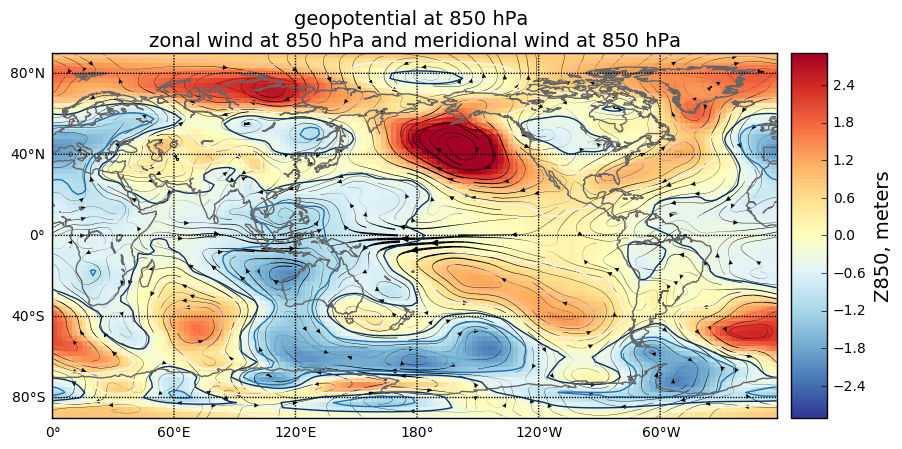

In [51]:
f = c.plot(stepp=3, res='c')

In [ ]:
# f = c.plotmap(stepp=2, domain=[120,220,-60,60], res='c')

In [52]:
f.savefig('/Users/nicolasf/Desktop/example_wind_vector_map_streamplot.png', dpi=200)

In [ ]:
hgt850.dset_dict

In [ ]:
uwnd850.dset_dict

In [ ]:
c.hgtcompos.dset_compos['composite_anomalies']

In [ ]:
vmin, vmax, levels, cmap = c._get_levels(c.hgtcompos.dset_compos['composite_anomalies'].data)

In [ ]:
vmin

In [ ]:
vmax

In [ ]:
levels